# Evaluation

## Metrics

The following metrics can be used if we assume the PUMAs follow the ground truth distribution.

#### Single column metrics

**𝜒2  test**

This metric uses the Chi-Squared test to compare the distributions of the two categorical columns. It returns the resulting p-value so that a small value indicates that we can reject the null hypothesis (i.e. and suggests that the distributions are different).

Notes:
- The sum of the observed and expected frequencies must be the same for the test to be valid.
- The test is invalid when the observed or expected frequencies in each category are too small. 
A typical rule is that all of the observed and expected frequencies should be at least 5.
- The test is not symmetric.

Reference:
https://github.com/sdv-dev/SDMetrics/tree/master/sdmetrics/single_table

#### Multi column metrics

**Detection metric**

This metric builds a LogisticRegression Classifier that learns to tell the synthetic data apart from the real data, which later on is evaluated using Cross Validation. The output of the metric is one minus the average ROC AUC score obtained.

Reference: https://github.com/sdv-dev/SDMetrics/tree/master/sdmetrics/single_table

**Dimension-wise prediction**

This task indirectly measures how well the model captures the interdimensional relationships of the real samples. We choose one dimension y to be the label. We then train two multi-class classifiers, one on the real data and one on the synthetic data. Then, we use the two models to predict the label of a test set pre-drawn from the real data. We can assume that the closer the performance of the model trained on the synthetic data is to that of the model trained on the real data, the better the quality of the synthetic dataset.

Reference: https://arxiv.org/pdf/1703.06490.pdf

#### Diversity metrics

**Sampling zeros**

They define sampling zeros as combinations of variables which are in the test set but not in the training set. We can examine how many sampling zeros are recovered using the models as a proportion of the total sampling zeros. 

They also define structural zeros as the individuals that are neither in the training data nor the test data. They say that we should minimize the amount of structural zeros. I'm not sure about that. 

Reference: https://arxiv.org/pdf/1909.07689.pdf

## Mount Google Drive, Link to folder & install requirements

In [ ]:
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd /content/gdrive/MyDrive/Maryland

/content/gdrive/MyDrive/Maryland


In [29]:
!pip install sdmetrics

  Attempting uninstall: pandas
    Found existing installation: pandas 1.2.4
    Uninstalling pandas-1.2.4:
      Successfully uninstalled pandas-1.2.4


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\yzc97\\anaconda3\\Lib\\site-packages\\~andas\\_libs\\algos.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:
# !pip install -qr requirements.txt

## Imports

In [1]:
# Miscellaneous
%matplotlib inline
from typing import Tuple
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
# from sdmetrics.single_table import CSTest
from dataclasses import dataclass

# My modules
# medWGAN-GP
from models import MedGAN, GAN, Autoencoder, VAE

# Gibbs
from models import  Gibbs
# medWGAN-GP training methods
from train import train_autoencoder, train_vae, train_gan
# Utils
from utils import to_device, train_test, generate_samples_vae, generate_samples, generate_samples_gibbs, project_samples
# Evaluation
from utils import DWP, sampling_zeros
# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tensorflow as tf
from tensorflow import keras


# Check if CUDA is available
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

## Data

In [2]:
# Load data and drop the state
train_df = pd.read_csv('../Data/train_only.csv', index_col=0)#.drop(["ST"], axis=1)
test_df = pd.read_csv('../Data/test_only.csv', index_col=0)#.drop(["ST"], axis=1)
# Make puma in range 0 to 4 (original pumas are 1201, 1202, 1203, 1204)
train_df['PUMA'] = train_df['PUMA'].apply(lambda x: x - 1201)
test_df['PUMA'] = test_df['PUMA'].apply(lambda x: x - 1201)
# To numpy arrays 
train = train_df.values
test = test_df.values
# To tensors
train_tensor = torch.tensor(train, dtype=torch.float32)
test_tensor = torch.tensor(test, dtype=torch.float32)

In [3]:
# DataLoader
batch_size = 64
train_loader = DataLoader(train_tensor,
                          batch_size=batch_size,
                          shuffle=False)
val_loader = DataLoader(test_tensor,
                        batch_size=batch_size,
                        shuffle=False)

## MedWGAN-GP


References: 

Embedding: [Generating Multi-label Discrete Patient Records
using Generative Adversarial Networks](https://arxiv.org/pdf/1703.06490.pdf)

The generator generates samples in the latent space of the encoder. The decoder then decodes it for the critic. 

GAN: [Generative Adverserial Nets](https://arxiv.org/pdf/1406.2661.pdf) 

WGAN: [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf) 


WGAN-GP: [Improved Training of Wasserstein GANs](https://arxiv.org/pdf/1704.00028.pdf)

"The recently proposed Wasserstein GAN (WGAN) makes progress toward stable training of GANs, but sometimes can still generate only poor samples or fail to converge. We find that these problems are often due to the use of weight clipping in WGAN to enforce a Lipschitz constraint on the critic, which can lead to undesired behavior. We propose an alternative to clipping weights: penalize the norm of gradient of the critic with respect to its input."



**Parameters**

In [4]:
# Params
N_sample = len(train_tensor)
batch_size = 64

# models'a args
@dataclass
class Arguments_gan:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/Maryland/data'
  batch_size: int = batch_size

  # Model
  input_dim: int = 11
  embedding_dim: int = 64
  random_dim: int = 100
  is_finetuning: bool = False
  hidden_D: Tuple[int, ...] = (32,)
  hidden_G: Tuple[int, ...] = (32,)

  # Optimization (inspired by WGAN paper)
  n_critic: int = 5
  lr: float = 0.00005
  epochs: int = 50
  lambda_gp: int = 10

  # Miscellaneous
  device: str = 'cpu'
  decoder: torch.nn.Module = None
  verbose: bool = True

@dataclass
class Arguments_ae:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/Maryland/data'
  batch_size: int = batch_size

  # Model
  input_dim: int = 11
  latent_dim: int = 64  # Overcomplete AE
  hidden: Tuple[int, ...] = (32,)

  # Optimization
  lr: float = 1e-3
  epochs: int = 50 
  p_zero: float = None  # if not None: Denoising AE 

  # Miscellaneous
  device: str = 'cpu'

In [5]:
# Ae arguments
args = Arguments_ae(batch_size=64,
                    input_dim=11,
                    latent_dim=64,  # Overcomplete AE
                    hidden=(32,),
                    lr=1e-3,
                    epochs=100,
                    p_zero=0,  # Denoizing Ae
                    device="cuda")

In [6]:
# Instanciation
autoencoder = Autoencoder(args)
print(autoencoder)

Autoencoder(
  (encoder): Encoder(
    (input_layer): Linear(in_features=11, out_features=32, bias=True)
    (layers): ModuleList()
    (output_layer): Linear(in_features=32, out_features=64, bias=True)
    (relu): ReLU()
    (tanh): Tanh()
  )
  (decoder): Decoder(
    (input_layer): Linear(in_features=64, out_features=32, bias=True)
    (layers): ModuleList()
    (output_layer): Linear(in_features=32, out_features=11, bias=True)
    (relu): ReLU()
  )
  (criterion): MSELoss()
)


In [7]:
# Training
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=args.lr)
train_autoencoder(autoencoder, train_loader, val_loader, optimizer, args)

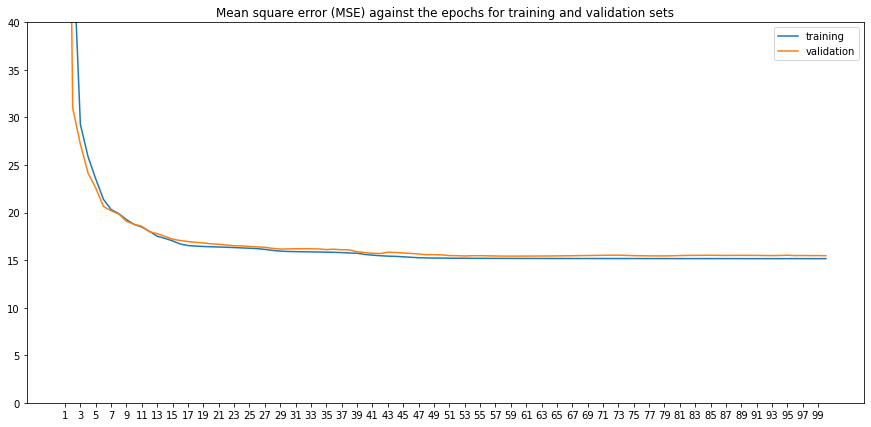

In [8]:
# Plot validation and training losses
epochs = range(1, args.epochs+1)
plt.figure(figsize=(15, 7))
plt.title("Mean square error (MSE) against the epochs for training and validation sets")
plt.plot(epochs, autoencoder.logs["train loss"], label="training")
plt.plot(epochs, autoencoder.logs["val loss"], label="validation")
plt.xticks(range(1, args.epochs+1, 2))
plt.ylim(0, 40)
plt.legend(loc=1)
plt.show()

In [9]:
torch.save(autoencoder.decoder, "../Saved_Models/decoder.pt")

**Training of medWGAN-GP**

In [10]:
# Gans' arguments 
args = Arguments_gan(epochs=1500,
                     input_dim=11,
                     hidden_D=(64,),
                     hidden_G=(64,),
                     lambda_gp=5,
                     is_finetuning=True,
                     decoder=torch.load("../Saved_Models/decoder.pt"),
                    #  decoder=autoencoder.decoder,
                     device="cuda",
                     verbose=False)

In [11]:
# Instanciation
gan = GAN(args)
gan.to(args.device)
print(gan)

GAN(
  (G): Generator(
    (decoder): Decoder(
      (input_layer): Linear(in_features=64, out_features=32, bias=True)
      (layers): ModuleList()
      (output_layer): Linear(in_features=32, out_features=11, bias=True)
      (relu): ReLU()
    )
    (input_layer): Linear(in_features=100, out_features=64, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=64, out_features=64, bias=True)
    (output_activation): Tanh()
  )
  (D): Discriminator(
    (input_layer): Linear(in_features=11, out_features=64, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [12]:
# Training 
optimizer_D = torch.optim.RMSprop(gan.D.parameters(), args.lr)
optimizer_G = torch.optim.RMSprop(gan.G.parameters(), args.lr)
train_gan(gan, train_loader, optimizer_D, optimizer_G, args)

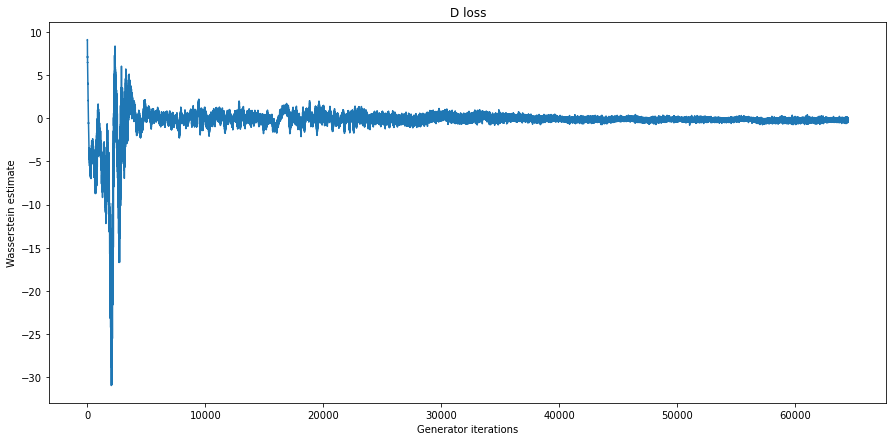

In [13]:
# Wasserstein distance
plt.figure(figsize=(15, 7))
plt.title("D loss")
plt.xlabel("Generator iterations")
plt.ylabel("Wasserstein estimate")
plt.plot(gan.logs["approx. EM distance"])
plt.show()

**Save and load**

In [14]:
torch.save(gan, "../Saved_Models/medWGAN-GP.pt")

In [15]:
gan = torch.load("../Saved_Models/medWGAN-GP.pt")

**Generate train data**

In [16]:
medGAN_train_df = pd.DataFrame(generate_samples(gan.G, train_df.shape[0], args), columns=train_df.columns)

In [17]:
# Domain of train set
train_domain = {}
for dim in train_df:
    train_domain[dim] = np.unique(train_df[dim])

In [18]:
dim_to_project = ["HINCP", "NP", "AGEP", "RAC1P", "ESR", "SEX", "WIF", "HUPAC", "HHT", "PUMA", "ST"]

In [19]:
# Inplace projection
project_samples(medGAN_train_df, dim_to_project, train_domain)

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA,ST
0,4.0,2.0,65.0,1.0,1.0,1.0,3.0,4.0,1.0,2.0,24.0
1,5.0,4.0,11.0,1.0,0.0,1.0,4.0,2.0,2.0,1.0,24.0
2,2.0,2.0,8.0,1.0,1.0,1.0,3.0,2.0,1.0,1.0,24.0
3,6.0,4.0,40.0,1.0,1.0,2.0,3.0,3.0,2.0,2.0,24.0
4,5.0,5.0,9.0,1.0,0.0,2.0,2.0,3.0,2.0,2.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...
13502,5.0,6.0,14.0,1.0,0.0,2.0,4.0,2.0,2.0,1.0,24.0
13503,5.0,4.0,45.0,1.0,6.0,2.0,3.0,4.0,2.0,1.0,24.0
13504,6.0,3.0,59.0,1.0,1.0,1.0,4.0,3.0,2.0,2.0,24.0
13505,5.0,4.0,5.0,1.0,0.0,1.0,3.0,2.0,2.0,2.0,24.0


**Generate test data**

In [20]:
medGAN_df = pd.DataFrame(generate_samples(gan.G, test_df.shape[0], args), columns=train_df.columns)

In [21]:
# Domain of train set
train_domain = {}
for dim in train_df:
    train_domain[dim] = np.unique(train_df[dim])

In [22]:
dim_to_project = ["HINCP", "NP", "AGEP", "RAC1P", "ESR", "SEX", "WIF", "HUPAC", "HHT", "PUMA", "ST"]

In [23]:
# Inplace projection
project_samples(medGAN_df, dim_to_project, train_domain)

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA,ST
0,5.0,3.0,67.0,1.0,1.0,2.0,3.0,4.0,1.0,2.0,24.0
1,4.0,4.0,3.0,1.0,0.0,2.0,3.0,1.0,2.0,1.0,24.0
2,5.0,5.0,14.0,1.0,0.0,1.0,3.0,2.0,2.0,2.0,24.0
3,6.0,4.0,52.0,1.0,1.0,2.0,3.0,3.0,2.0,2.0,24.0
4,6.0,4.0,79.0,1.0,1.0,1.0,4.0,4.0,1.0,2.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...
5785,3.0,3.0,20.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,24.0
5786,5.0,3.0,68.0,1.0,6.0,1.0,2.0,4.0,1.0,1.0,24.0
5787,4.0,3.0,63.0,1.0,6.0,1.0,2.0,4.0,1.0,1.0,24.0
5788,5.0,5.0,12.0,5.0,0.0,1.0,4.0,2.0,1.0,1.0,24.0


**Visualization of the marginals**

C:\Users\yzc97\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


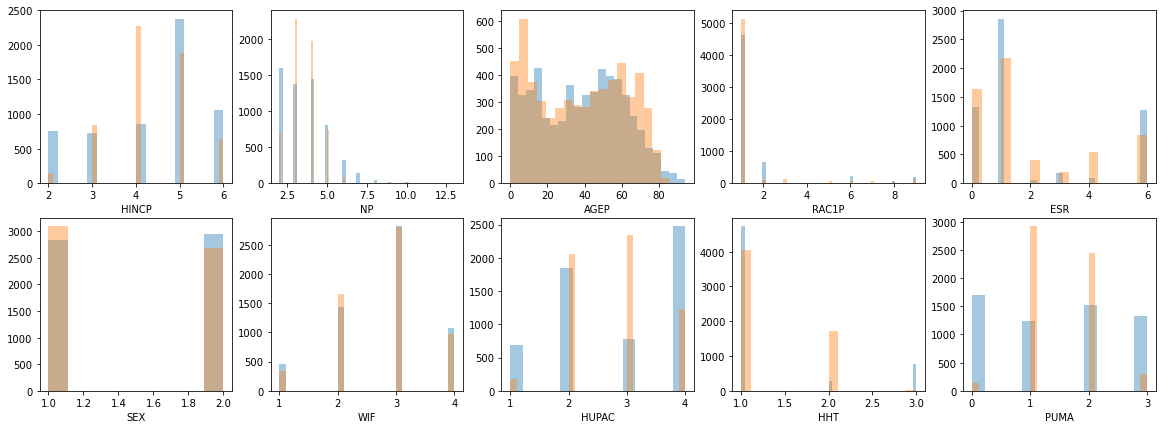

In [24]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
k = 0
col = train_df.columns
for i in range(2):
  for j in range(5):
    sns.distplot(test_df[col[k]], kde=False, ax=ax[i, j])
    sns.distplot(medGAN_df[col[k]], kde=False, ax=ax[i, j])
    k += 1
plt.show()

**Single column metrics**

In [25]:
from sdmetrics.single_column.statistical.cstest import CSTest

In [26]:
cs_test = CSTest()
print(f"{cs_test.name} \nmin={cs_test.min_value}, max={cs_test.max_value}\nGoal={cs_test.goal}\n")
for col in test_df.columns:
    print(f"{col} \t {cs_test.compute(test_df[col], medGAN_df[col]):.2f}")

Chi-Squared 
min=0.0, max=1.0
Goal=Goal.MAXIMIZE

HINCP 	 0.97
NP 	 1.00
AGEP 	 1.00
RAC1P 	 0.97
ESR 	 0.97
SEX 	 0.93
WIF 	 1.00
HUPAC 	 0.87
HHT 	 0.51
PUMA 	 0.83
ST 	 1.00


**Detection metric**

In [27]:
from sdmetrics.single_table.detection.sklearn import LogisticDetection

In [28]:
logisticDetection = LogisticDetection()
print(f"{logisticDetection.name} \nmin={logisticDetection.min_value}, max={logisticDetection.max_value}\nGoal={logisticDetection.goal}\n")
print(logisticDetection.compute(test_df, medGAN_df))

LogisticRegression Detection 
min=0.0, max=1.0
Goal=Goal.MAXIMIZE

0.9072484272508434


**Dimension-wise prediction**

In [29]:
print("Dimension-wise prediction (DWP)")
print("min=0.0, max=1.0\nGoal=Maximize")
score_real = {}
score_synthetic = {}
for col in test_df.columns:
    if col == "ST":
        continue
    score_real[col] = DWP(train_df, test_df, col)
    try:
        score_synthetic[col] = DWP(medGAN_train_df, test_df, col)
    except:
        score_synthetic[col] = np.NAN
print("\n")
for col in test_df.columns:
    if col == "ST":
        continue
    print(f"label={col}\nReal={score_real[col]:.2f}, Synthetic={score_synthetic[col]:.2f}")

Dimension-wise prediction (DWP)
min=0.0, max=1.0
Goal=Maximize


C:\Users\yzc97\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\yzc97\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_



label=HINCP
Real=0.32, Synthetic=0.26
label=NP
Real=0.41, Synthetic=0.31
label=AGEP
Real=0.04, Synthetic=0.02
label=RAC1P
Real=0.72, Synthetic=0.67
label=ESR
Real=0.80, Synthetic=0.62
label=SEX
Real=0.54, Synthetic=0.50
label=WIF
Real=0.56, Synthetic=0.49
label=HUPAC
Real=0.64, Synthetic=0.36
label=HHT
Real=0.76, Synthetic=0.57
label=PUMA
Real=0.33, Synthetic=0.15


C:\Users\yzc97\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Sampling zeros**

In [30]:
s_z = sampling_zeros(train_df, test_df, medGAN_train_df)
print(f"{s_z} sampling zeros on {medGAN_train_df.shape[0]} synthetic samples")

80 sampling zeros on 13507 synthetic samples


## VAE-GAN

**Parameters**

In [5]:
# Params
N_sample = len(train_tensor)
batch_size = 64

# models'a args
@dataclass
class Arguments_gan:
  # Data
  data_folder: str = '../Data'
  batch_size: int = batch_size

  # Model
  input_dim: int = 11
  embedding_dim: int = 64
  random_dim: int = 100
  is_finetuning: bool = False
  hidden_D: Tuple[int, ...] = (32,)
  hidden_G: Tuple[int, ...] = (32,)

  # Optimization (inspired by WGAN paper)
  n_critic: int = 5
  lr: float = 0.00005
  epochs: int = 50
  lambda_gp: int = 10

  # Miscellaneous
  device: str = 'cpu'
  decoder: torch.nn.Module = None
  verbose: bool = True

@dataclass
class Arguments_vae:
  # Data
  data_folder: str = '../Data'
  batch_size: int = batch_size

  # Model
  input_dim: int = 11
  latent_dim: int = 64  # Overcomplete AE
  hidden: Tuple[int, ...] = (32,)

  # Optimization
  lr: float = 1e-3
  epochs: int = 50 
  p_zero: float = None  # if not None: Denoising AE 

  # Miscellaneous
  device: str = 'cpu'


**Pre-train the embedding**

In [6]:
# Vae arguments
args = Arguments_vae(batch_size=64,
                    input_dim=11,
                    latent_dim=64,  # Overcomplete VAE
                    hidden=(32,),
                    lr=1e-3,
                    epochs=100,
                    p_zero=0,  # Denoizing Vae
                    device="cuda")

In [7]:
# Instanciation
vae = VAE(args)
print(vae)

VAE(
  (encoder): Encoder(
    (input_layer): Linear(in_features=11, out_features=32, bias=True)
    (layers): ModuleList()
    (output_layer): Linear(in_features=32, out_features=64, bias=True)
    (relu): ReLU()
    (tanh): Tanh()
  )
  (decoder): Decoder(
    (input_layer): Linear(in_features=64, out_features=32, bias=True)
    (layers): ModuleList()
    (output_layer): Linear(in_features=32, out_features=11, bias=True)
    (relu): ReLU()
  )
  (criterion): MSELoss()
)


In [8]:
# Training
optimizer = torch.optim.Adam(vae.parameters(), lr=args.lr)
train_vae(vae, train_loader, val_loader, optimizer, args)

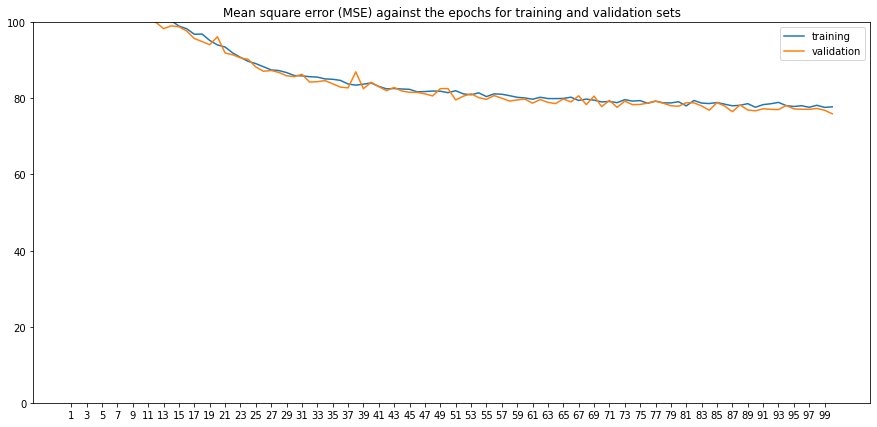

In [12]:
# Plot validation and training losses
epochs = range(1, args.epochs+1)
plt.figure(figsize=(15, 7))
plt.title("Mean square error (MSE) against the epochs for training and validation sets")
plt.plot(epochs, vae.logs["train loss"], label="training")
plt.plot(epochs, vae.logs["val loss"], label="validation")
plt.xticks(range(1, args.epochs+1, 2))
plt.ylim(0, 100)
plt.legend(loc=1)
plt.show()

In [13]:
 torch.save(vae.decoder, "../Data/VAEdecoder.pt")

**Training of medWGAN-GP**

In [14]:
# Gans' arguments 
args = Arguments_gan(epochs=1500,
                     input_dim=11,
                     hidden_D=(64,),
                     hidden_G=(64,),
                     lambda_gp=5,
                     is_finetuning=True,
                     decoder=torch.load("../Saved_Models/VAEdecoder.pt"),
                    #  decoder=autoencoder.decoder,
                     device="cuda",
                     verbose=False)

In [15]:
# Instanciation
gan = GAN(args)
gan.to(args.device)
print(gan)

GAN(
  (G): Generator(
    (decoder): Decoder(
      (input_layer): Linear(in_features=64, out_features=32, bias=True)
      (layers): ModuleList()
      (output_layer): Linear(in_features=32, out_features=11, bias=True)
      (relu): ReLU()
    )
    (input_layer): Linear(in_features=100, out_features=64, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=64, out_features=64, bias=True)
    (output_activation): Tanh()
  )
  (D): Discriminator(
    (input_layer): Linear(in_features=11, out_features=64, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList()
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [16]:
# Training 
optimizer_D = torch.optim.RMSprop(gan.D.parameters(), args.lr)
optimizer_G = torch.optim.RMSprop(gan.G.parameters(), args.lr)
train_gan(gan, train_loader, optimizer_D, optimizer_G, args)

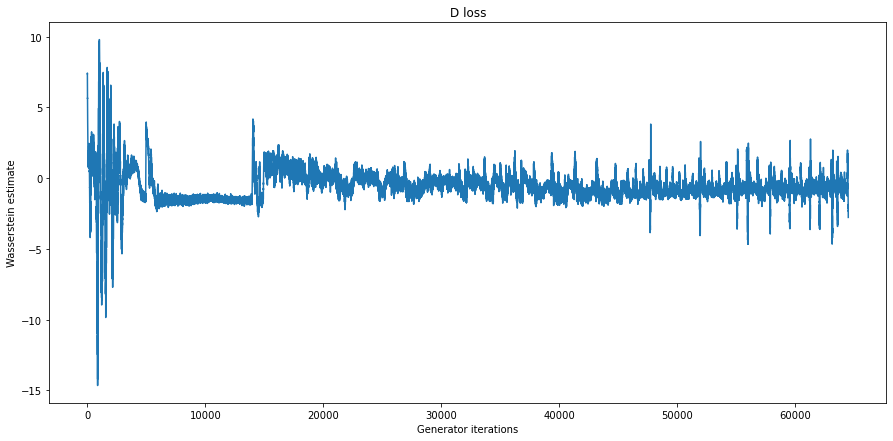

In [17]:
# Wasserstein distance
plt.figure(figsize=(15, 7))
plt.title("D loss")
plt.xlabel("Generator iterations")
plt.ylabel("Wasserstein estimate")
plt.plot(gan.logs["approx. EM distance"])
plt.show()

**Save and load**

In [18]:
 torch.save(gan, "../Saved_Models/VAE-GAN.pt")

In [19]:
gan = torch.load("../Saved_Models/VAE-GAN.pt")

**Generate train data**

In [20]:
vaegan_train_df = pd.DataFrame(generate_samples(gan.G, train_df.shape[0], args), columns=train_df.columns)

In [21]:
# Domain of train set
train_domain = {}
for dim in train_df:
    train_domain[dim] = np.unique(train_df[dim])

In [22]:
dim_to_project = ["HINCP", "NP", "AGEP", "RAC1P", "ESR", "SEX", "WIF", "HUPAC", "HHT", "PUMA", "ST"]

In [23]:
# Inplace projection
project_samples(vaegan_train_df, dim_to_project, train_domain)

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA,ST
0,3.0,5.0,51.0,9.0,4.0,2.0,3.0,2.0,2.0,1.0,24.0
1,5.0,3.0,72.0,9.0,6.0,1.0,3.0,4.0,1.0,1.0,24.0
2,4.0,4.0,46.0,9.0,4.0,2.0,3.0,2.0,2.0,2.0,24.0
3,3.0,3.0,62.0,9.0,6.0,2.0,2.0,3.0,1.0,1.0,24.0
4,5.0,4.0,4.0,9.0,0.0,2.0,2.0,3.0,1.0,3.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...
13502,5.0,5.0,9.0,9.0,0.0,2.0,4.0,3.0,1.0,1.0,24.0
13503,6.0,3.0,64.0,9.0,6.0,1.0,3.0,4.0,1.0,3.0,24.0
13504,4.0,4.0,31.0,8.0,0.0,2.0,3.0,2.0,1.0,2.0,24.0
13505,2.0,5.0,1.0,9.0,0.0,2.0,2.0,3.0,1.0,2.0,24.0


**Generate test data**

In [24]:
vaegan_df = pd.DataFrame(generate_samples(gan.G, test_df.shape[0], args), columns=train_df.columns)

apply projection on original train domain

In [25]:
# Domain of train set
train_domain = {}
for dim in train_df:
    train_domain[dim] = np.unique(train_df[dim])

In [26]:
dim_to_project = ["HINCP", "NP", "AGEP", "RAC1P", "ESR", "SEX", "WIF", "HUPAC", "HHT", "PUMA", "ST"]

In [27]:
# Inplace projection
project_samples(vaegan_df, dim_to_project, train_domain)

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT,PUMA,ST
0,4.0,4.0,49.0,9.0,3.0,2.0,3.0,3.0,1.0,0.0,24.0
1,6.0,2.0,49.0,9.0,0.0,2.0,3.0,3.0,1.0,2.0,24.0
2,4.0,4.0,53.0,9.0,6.0,2.0,2.0,3.0,1.0,2.0,24.0
3,5.0,3.0,74.0,9.0,6.0,2.0,2.0,4.0,1.0,1.0,24.0
4,3.0,3.0,55.0,8.0,6.0,2.0,1.0,3.0,2.0,1.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...
5785,3.0,3.0,33.0,9.0,0.0,2.0,3.0,3.0,2.0,2.0,24.0
5786,4.0,5.0,51.0,9.0,0.0,1.0,4.0,1.0,3.0,3.0,24.0
5787,6.0,2.0,57.0,9.0,0.0,1.0,4.0,4.0,2.0,3.0,24.0
5788,3.0,4.0,20.0,9.0,0.0,2.0,3.0,2.0,1.0,2.0,24.0


**Visualization of the marginals**

C:\Users\yzc97\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


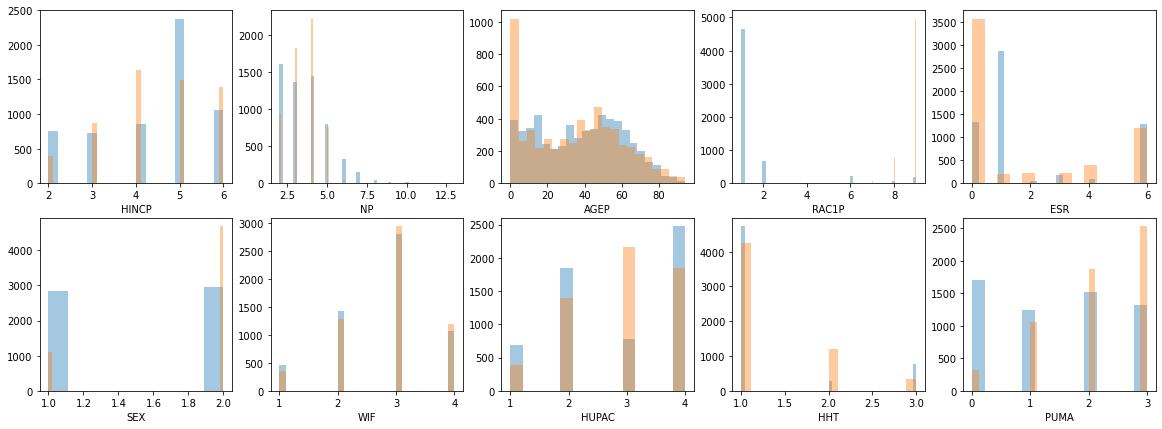

In [28]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
k = 0
col = train_df.columns
for i in range(2):
  for j in range(5):
    sns.distplot(test_df[col[k]], kde=False, ax=ax[i, j])
    sns.distplot(vaegan_df[col[k]], kde=False, ax=ax[i, j])
    k += 1
plt.show()

**Single column metrics**

In [29]:
from sdmetrics.single_column.statistical.cstest import CSTest

In [30]:
cs_test = CSTest()
print(f"{cs_test.name} \nmin={cs_test.min_value}, max={cs_test.max_value}\nGoal={cs_test.goal}\n")
for col in test_df.columns:
    print(f"{col} \t {cs_test.compute(test_df[col], vaegan_df[col]):.2f}")

Chi-Squared 
min=0.0, max=1.0
Goal=Goal.MAXIMIZE

HINCP 	 0.99
NP 	 1.00
AGEP 	 1.00
RAC1P 	 0.00
ESR 	 0.93
SEX 	 0.55
WIF 	 1.00
HUPAC 	 0.92
HHT 	 0.77
PUMA 	 0.94
ST 	 1.00


**Detection metric**


In [31]:
from sdmetrics.single_table.detection.sklearn import LogisticDetection

In [32]:
logisticDetection = LogisticDetection()
print(f"{logisticDetection.name} \nmin={logisticDetection.min_value}, max={logisticDetection.max_value}\nGoal={logisticDetection.goal}\n")
print(logisticDetection.compute(test_df, vaegan_df))

LogisticRegression Detection 
min=0.0, max=1.0
Goal=Goal.MAXIMIZE

0.010667221491404866


**Dimension-wise prediction**


In [33]:
print("Dimension-wise prediction (DWP)")
print("min=0.0, max=1.0\nGoal=Maximize")
score_real = {}
score_synthetic = {}
for col in test_df.columns:
    if col == "ST":
        continue
    score_real[col] = DWP(train_df, test_df, col)
    try:
        score_synthetic[col] = DWP(vaegan_train_df, test_df, col)
    except:
        score_synthetic[col] = np.NAN
print("\n")
for col in test_df.columns:
    if col == "ST":
        continue
    print(f"label={col}\nReal={score_real[col]:.2f}, Synthetic={score_synthetic[col]:.2f}")

Dimension-wise prediction (DWP)
min=0.0, max=1.0
Goal=Maximize


C:\Users\yzc97\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\yzc97\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_



label=HINCP
Real=0.32, Synthetic=0.28
label=NP
Real=0.41, Synthetic=0.26
label=AGEP
Real=0.04, Synthetic=0.00
label=RAC1P
Real=0.72, Synthetic=0.00
label=ESR
Real=0.80, Synthetic=0.12
label=SEX
Real=0.54, Synthetic=0.50
label=WIF
Real=0.56, Synthetic=0.31
label=HUPAC
Real=0.64, Synthetic=0.05
label=HHT
Real=0.76, Synthetic=0.51
label=PUMA
Real=0.33, Synthetic=0.17


**Sampling zeros**

In [34]:
s_z = sampling_zeros(train_df, test_df, vaegan_train_df)
print(f"{s_z} sampling zeros on {vaegan_train_df.shape[0]} synthetic samples")

3 sampling zeros on 13507 synthetic samples


## IPF



The IPF based techniques involve two step process. In the fitting step, a Contingency Table (CT) is fitted to the available marginals. PUMS is used to initialize the CT. The underlying assumption here is that the sample represents the true correlation structure among the attributes. The second step of IPF based techniques involves creating the synthetic population using the fitted CT. This is done by cloning/replication of the sample, based on cell weights. The fractions are incorporated in the synthetic population using Inverse Transform Sampling in a Monte Carlo simulation

Unlike GAN and Gibbs, we don't assume that the PUMA sample represents the thue distribution. How to evaluate IPF accordingly?

In [ ]:
# Generated data 
ipf_df = pd.read_csv("/content/gdrive/MyDrive/Maryland/data/IPFAllVariables.csv")


**Unique samples**

In [ ]:
puma1201 = pd.concat([train_df[train_df["PUMA"] == 0], test_df[test_df["PUMA"] == 0]])
puma1201.drop(["PUMA", "ST"], axis=1, inplace=True)

In [ ]:
uniques_1201 = puma1201.groupby(puma1201.columns.tolist(),as_index=False).size()
print(uniques_1201.shape[0])

4880


In [ ]:
uniques = ipf_df.groupby(ipf_df.columns.tolist(),as_index=False).size()
print(f"{uniques.shape[0]} unique samples on {ipf_df.shape[0]} samples ({uniques.shape[0]/ipf_df.shape[0]:.3f}%)")

4492 unique samples on 174187 samples (0.026%)


**Intersection with 1201**

In [ ]:
print(f"{pd.merge(puma1201, uniques, how='inner').shape[0]} samples in the intersection of the synthetic population and the original population")
print(f"for {puma1201.shape[0]} samples in the original population")

383 samples in the intersection of the synthetic population and the original population
for 5778 samples in the original population


**Vizualisation of the marginals**

In [ ]:
ipf_df = ipf_df.sample(n=test_df.shape[0], random_state=42, axis=0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


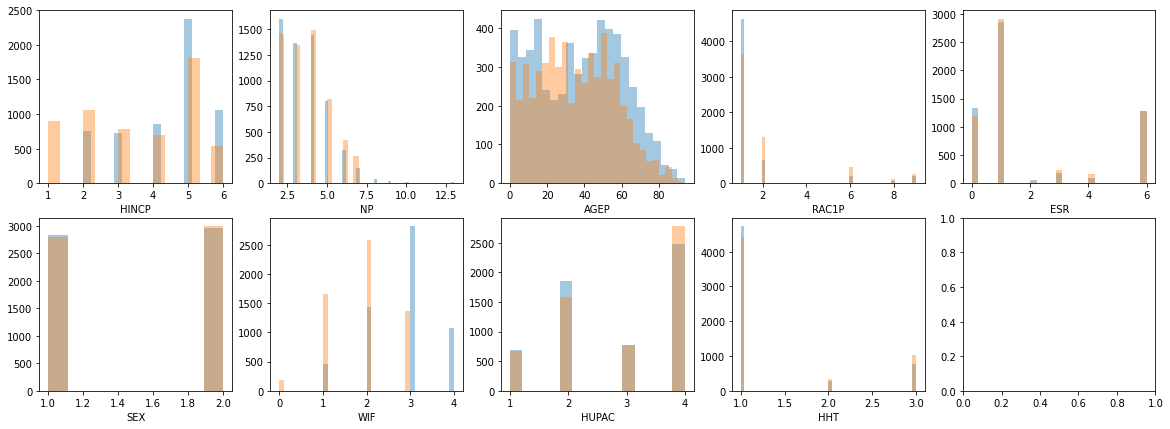

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
k = 0
col = train_df.columns
for i in range(2):
  for j in range(5):
    if col[k] == "PUMA": 
        break
    sns.distplot(test_df[col[k]], kde=False, ax=ax[i, j])
    sns.distplot(ipf_df[col[k]], kde=False, ax=ax[i, j])
    k += 1
plt.show()

**$\chi^2$ test**

In [ ]:
cs_test = CSTest()
print(f"{cs_test.name} \nmin={cs_test.min_value}, max={cs_test.max_value}\nGoal={cs_test.goal}\n")
for col in ipf_df.columns:
    print(f"{col} \t {cs_test.compute(test_df[col], ipf_df[col]):.2f}")

Chi-Squared 
min=0.0, max=1.0
Goal=Goal.MAXIMIZE

HINCP 	 0.00
NP 	 1.00
AGEP 	 1.00
RAC1P 	 1.00
ESR 	 1.00
SEX 	 0.99
WIF 	 0.00
HUPAC 	 1.00
HHT 	 0.99


/usr/local/lib/python3.7/dist-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value 1 in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')
/usr/local/lib/python3.7/dist-packages/sdmetrics/utils.py:62: UserWarning: Unexpected value 0 in synthetic data.
  warnings.warn(f'Unexpected value {value} in synthetic data.')


**Detection metric**

In [ ]:
logisticDetection = LogisticDetection()
print(f"{logisticDetection.name} \nmin={logisticDetection.min_value}, max={logisticDetection.max_value}\nGoal={logisticDetection.goal}\n")
print(logisticDetection.compute(test_df.drop(["PUMA", "ST"], axis=1), ipf_df))

LogisticRegression Detection 
min=0.0, max=1.0
Goal=Goal.MAXIMIZE

0.3710102284625091


**DWP**

We need to be carefull! We should only show the training data to IPF when training... TODO 

In [ ]:
print("Dimension-wise prediction (DWP)")
print("min=0.0, max=1.0\nGoal=Maximize")
score_real = {}
score_synthetic = {}
for col in ipf_df.columns:
    score_real[col] = DWP(train_df.drop(["PUMA", "ST"], axis=1), test_df.drop(["PUMA", "ST"], axis=1), col)
    score_synthetic[col] = DWP(ipf_df, test_df.drop(["PUMA", "ST"], axis=1), col)
print("\n")
for col in ipf_df.columns:
    print(f"label={col}\nReal={score_real[col]:.2f}, Synthetic={score_synthetic[col]:.2f}")

Dimension-wise prediction (DWP)
min=0.0, max=1.0
Goal=Maximize


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




label=HINCP
Real=0.31, Synthetic=0.28
label=NP
Real=0.40, Synthetic=0.32
label=AGEP
Real=0.04, Synthetic=0.03
label=RAC1P
Real=0.71, Synthetic=0.73
label=ESR
Real=0.80, Synthetic=0.74
label=SEX
Real=0.54, Synthetic=0.54
label=WIF
Real=0.56, Synthetic=0.19
label=HUPAC
Real=0.64, Synthetic=0.53
label=HHT
Real=0.76, Synthetic=0.74


## Gibbs sampling

Ref: [How to generate micro-agents? A deep generative modeling approach to population synthesis.](https://reader.elsevier.com/reader/sd/pii/S0968090X1831180X?token=8ED8DCD28D5EBD45B3C3D18D1926A80F4C0A3CDCD3DF4DD8BB276515E853A7C714619135C4F7C880088840D6618B5DCD&originRegion=us-east-1&originCreation=20211108140650) 

In statistics, Gibbs sampling or a Gibbs sampler is a Markov chain Monte Carlo (MCMC) algorithm for obtaining a sequence of observations which are approximated from a specified multivariate probability distribution by sampling from the conditional distributions. 

First, we select a random example from the training set to be our initial value $x^{0}$. Then each attribute $x_i^{k+1}$ is updated according to $P(x_i|x_1^{k+1}, \ldots x_{i-1}^{k+1}, x_{i+1}^{k}, \ldots, x_d^{k})$ until all the components are updated. The process is repeated using the new sample as a starting point until we get the desired number of sample. 

In the simplest case, we use the empirical conditional probabilities (ECDF) to compute the conditionals $P(x_i|x_1^{k+1}, \ldots x_{i-1}^{k+1}, x_{i+1}^{k}, \ldots, x_d^{k})$. That is, we select all the examples in the training set that have the same values for the dimensions on which we conditioned (as a frequency table or counts by category).

Using the full and consistent conditionals, if the Gibbs sampler is ran for an extended amount of iterations, it eventually reaches a stationary state (warm up phase). At that point any draw will be as if the draw was from p(x). To avoid the correlation between the consecutive draws, certain number of draws between two recorded draws are skipped. (see simulation based population synthesis for details)


Challenges:
- **Curse of dimensionality** The amount of data to uniformly fill a hypercube grows exponentially with its dimensions. For higher dimensions, it may lead to the existence of isolated or loosely connected probability density islands (in the ECDF). We face the same problem when a dimension has many possible values (p.e. the age). We can try to discretize these dimensions with uniform bins.
- **Sampling zero** Sampling agents which are missing from the original sample but exist in the real population. When using a frequency table, we exactly replicate the examples of the training sample. In *Simulation Based Population Synthesis* (https://www.sciencedirect.com/science/article/pii/S0191261513001720), they estimate the conditionals with discrete choice models. And we can also use regression trees.  

**9 dimensions**

In [ ]:
n_warmup = 1000
n = train_df.shape[0]
gibbs_sampler = Gibbs()

In [ ]:
gibbs_df = generate_samples_gibbs(gibbs_sampler, train_df, n_warmup + n)
gibbs_df = gibbs_df.loc[n_warmup:]

**Visualization of the marginals**

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


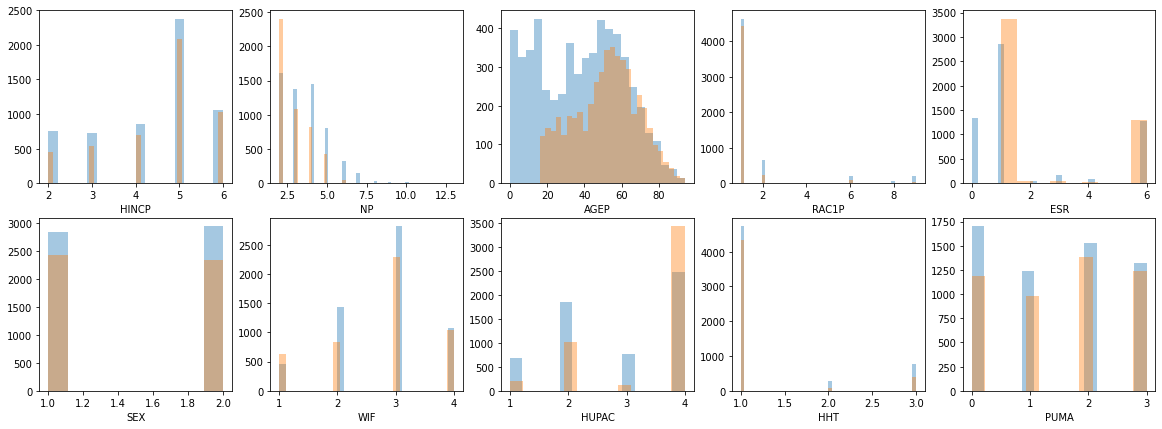

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20, 7))
k = 0
col = train_df.columns
for i in range(2):
  for j in range(5):
    sns.distplot(test_df[col[k]], kde=False, ax=ax[i, j])
    sns.distplot(gibbs_df.iloc[:test_df.shape[0]][col[k]], kde=False, ax=ax[i, j])
    k += 1
plt.show()

**Single column metrics**

In [ ]:
cs_test = CSTest()
print(f"{cs_test.name} \nmin={cs_test.min_value}, max={cs_test.max_value}\nGoal={cs_test.goal}\n")
for col in test_df.columns:
    print(f"{col} \t {cs_test.compute(test_df[col], gibbs_df[col]):.2f}")

Chi-Squared 
min=0.0, max=1.0
Goal=Goal.MAXIMIZE

HINCP 	 1.00
NP 	 1.00
AGEP 	 1.00
RAC1P 	 1.00
ESR 	 1.00
SEX 	 0.96
WIF 	 1.00
HUPAC 	 0.96
HHT 	 0.97
PUMA 	 1.00
ST 	 1.00


**Detection metric**

In [ ]:
logisticDetection = LogisticDetection()
print(f"{logisticDetection.name} \nmin={logisticDetection.min_value}, max={logisticDetection.max_value}\nGoal={logisticDetection.goal}\n")
print(logisticDetection.compute(test_df, gibbs_df))

LogisticRegression Detection 
min=0.0, max=1.0
Goal=Goal.MAXIMIZE

0.6040106159592069


**Dimension-wise prediction**

In [ ]:
print("Dimension-wise prediction (DWP)")
print("min=0.0, max=1.0\nGoal=Maximize")
score_real = {}
score_synthetic = {}
for col in test_df.columns:
    if col == "ST":
        continue
    score_real[col] = DWP(train_df, test_df, col)
    try:
        score_synthetic[col] = DWP(medGAN_train_df, test_df, col)
    except:
        score_synthetic[col] = np.NAN
print("\n")
for col in test_df.columns:
    if col == "ST":
        continue
    print(f"label={col}\nReal={score_real[col]:.2f}, Synthetic={score_synthetic[col]:.2f}")

Dimension-wise prediction (DWP)
min=0.0, max=1.0
Goal=Maximize


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




label=HINCP
Real=0.32, Synthetic=0.27
label=NP
Real=0.41, Synthetic=0.38
label=AGEP
Real=0.04, Synthetic=0.02
label=RAC1P
Real=0.72, Synthetic=0.71
label=ESR
Real=0.80, Synthetic=0.73
label=SEX
Real=0.54, Synthetic=0.50
label=WIF
Real=0.56, Synthetic=0.49
label=HUPAC
Real=0.64, Synthetic=0.44
label=HHT
Real=0.76, Synthetic=0.65
label=PUMA
Real=0.33, Synthetic=0.20


**Sampling zeros**

In [ ]:
s_z = sampling_zeros(train_df, test_df, gibbs_df)
print(f"{s_z} sampling zeros on {gibbs_df.shape[0]} synthetic samples")

0 sampling zeros on 13507 synthetic samples
